In [1]:
##imports/path setup

import os
from pathlib import Path
import numpy as np
import geopandas as gpd
import rasterio
from rasterio import mask
import fiona
import shapely
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (8, 6)

BASE_DIR = Path.cwd()
DATA_RAW = BASE_DIR / "data_raw"
FIG_DIR = BASE_DIR / "figs"

FIG_DIR.mkdir(exist_ok=True)

print("BASE_DIR:", BASE_DIR)
print("DATA_RAW exists:", DATA_RAW.is_dir())
print("FIG_DIR:", FIG_DIR)


BASE_DIR: C:\Users\Rbrig\fossil_creek_project
DATA_RAW exists: True
FIG_DIR: C:\Users\Rbrig\fossil_creek_project\figs


In [2]:
##load HUC10 layer & filter to Fossil Creek AOI

gdb_path = DATA_RAW / "WBD_15_HU2_GDB.gdb"
print("GDB exists:", gdb_path.is_dir())

# Optional: inspect available layers once
with fiona.Env():
    layers = fiona.listlayers(gdb_path)
layers[:10]


GDB exists: True


['ExternalCrosswalk',
 'FeatureToMetadata',
 'HUMod',
 'MetaProcessDetail',
 'MetaSourceDetail',
 'ProcessingParameters',
 'UpdateStatus',
 'WBDLine',
 'WBDHU8',
 'WBDHU6']

In [3]:
##read the HUC10 layer and select Fossil Creek–Verde River

hu_layer = "WBDHU10"   ##based on your earlier work; change if needed

aoi_all = gpd.read_file(gdb_path, layer=hu_layer)
print("AOI layer loaded. Number of features:", len(aoi_all))
print(aoi_all.columns)

aoi = aoi_all[aoi_all["name"] == "Fossil Creek-Verde River"].copy()
print("Selected AOI features:", len(aoi))
aoi[["name", "huc10", "areasqkm"]]


AOI layer loaded. Number of features: 630
Index(['tnmid', 'metasourceid', 'sourcedatadesc', 'sourceoriginator',
       'sourcefeatureid', 'loaddate', 'referencegnis_ids', 'areaacres',
       'areasqkm', 'states', 'huc10', 'name', 'hutype', 'humod',
       'shape_Length', 'shape_Area', 'geometry'],
      dtype='object')
Selected AOI features: 1


,name,huc10,areasqkm
580,Fossil Creek-Verde River,1506020303,775.39


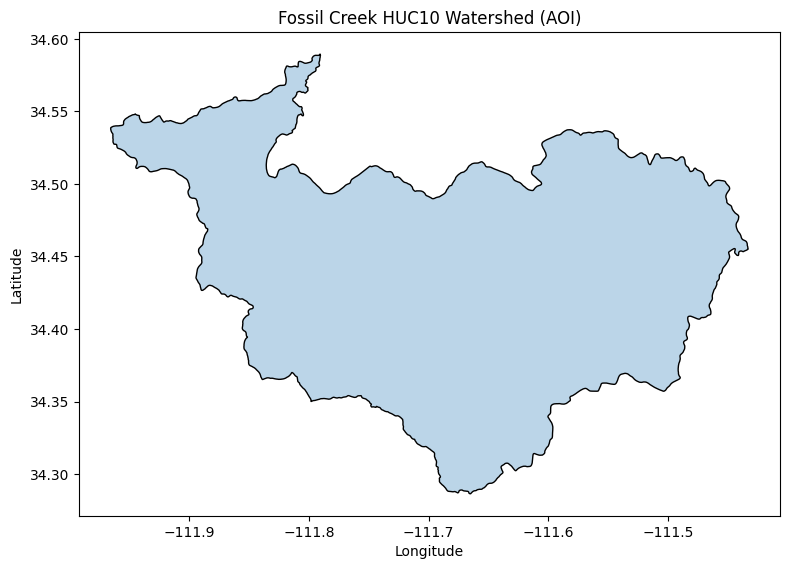

Saved: C:\Users\Rbrig\fossil_creek_project\figs\aoi_map.png


In [4]:
##plot AOI boundary & save AOI map

fig, ax = plt.subplots()
aoi.boundary.plot(ax=ax, linewidth=1, color="black")
aoi.plot(ax=ax, alpha=0.3)
ax.set_title("Fossil Creek HUC10 Watershed (AOI)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.tight_layout()
out_path = FIG_DIR / "aoi_map.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [5]:
##load Backbone Fire perimeters & select final perimeter

fire_dir = DATA_RAW / "BackboneFire_2021"
fire_shp = fire_dir / "Perimeters.shp"

print("Fire shapefile exists:", fire_shp.is_file())

backbone_fire = gpd.read_file(fire_shp)
print("Backbone fire features:", len(backbone_fire))
print(backbone_fire.columns[:10])

backbone_fire["poly_Featu"].unique()


Fire shapefile exists: True
Backbone fire features: 5
Index(['poly_Sourc', 'poly_Incid', 'poly_Featu', 'poly_MapMe', 'poly_GISAc',
       'poly_Delet', 'poly_Fea_1', 'poly_Fea_2', 'poly_IsVis', 'poly_Creat'],
      dtype='object')


array(['Wildfire Daily Fire Perimeter', 'Wildfire Final Fire Perimeter'],
      dtype=object)

In [6]:
##filter to 'Wildfire Final Fire Perimeter' & fix invalid geometries

backbone_fire_final = backbone_fire[
    backbone_fire["poly_Featu"] == "Wildfire Final Fire Perimeter"
].copy()

print("Final perimeter count:", len(backbone_fire_final))

##fix invalid geometries before dissolve
backbone_fire_final["geometry"] = backbone_fire_final.geometry.apply(
    lambda geom: shapely.make_valid(geom)
)

##dissolve all final perimeters into single polygon
backbone_fire_final_diss = backbone_fire_final.dissolve()
print("Rows after dissolve:", len(backbone_fire_final_diss))


Final perimeter count: 2
Rows after dissolve: 1


In [7]:
##reproject AOI & fire to UTM 12N & compute areas

target_crs = 32612  # EPSG:32612

aoi_utm = aoi.to_crs(target_crs)
fire_utm = backbone_fire_final_diss.to_crs(target_crs)

# Intersection: fire within AOI
fire_in_aoi = gpd.overlay(fire_utm, aoi_utm, how="intersection")
print("Fire-in-AOI features:", len(fire_in_aoi))

aoi_area_m2 = aoi_utm.geometry.area.sum()
fire_area_m2 = fire_in_aoi.geometry.area.sum()

aoi_area_km2 = aoi_area_m2 / 1e6
fire_area_km2 = fire_area_m2 / 1e6
percent_burned = (fire_area_km2 / aoi_area_km2) * 100

print(f"AOI area: {aoi_area_km2:.2f} km²")
print(f"Burned area: {fire_area_km2:.2f} km²")
print(f"Percent burned: {percent_burned:.2f}%")


Fire-in-AOI features: 1
AOI area: 774.85 km²
Burned area: 165.11 km²
Percent burned: 21.31%


C:\Users\Rbrig\AppData\Local\Temp\ipykernel_11440\3448390180.py:12: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


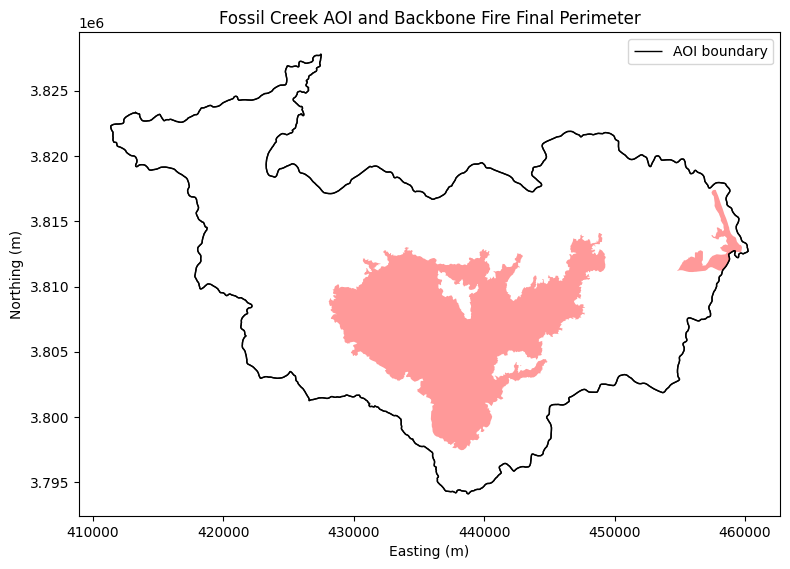

Saved: C:\Users\Rbrig\fossil_creek_project\figs\aoi_backbone_overlay.png


In [8]:
##plot AOI and burned area overlay, save figure

fig, ax = plt.subplots()
aoi_utm.boundary.plot(ax=ax, color="black", linewidth=1, label="AOI boundary")
aoi_utm.plot(ax=ax, color="none")

fire_in_aoi.plot(ax=ax, color="red", alpha=0.4, label="Backbone Fire (in AOI)")

ax.set_title("Fossil Creek AOI and Backbone Fire Final Perimeter")
ax.set_xlabel("Easting (m)")
ax.set_ylabel("Northing (m)")
ax.legend()

plt.tight_layout()
out_path = FIG_DIR / "aoi_backbone_overlay.png"
plt.savefig(out_path, dpi=300)
plt.show()

print("Saved:", out_path)


In [9]:
##helper to load bands/return masked arrays

def load_landsat_scene(scene_dir, red_name, nir_name, swir2_name, qa_name):
    """
    Load Landsat bands and QA_PIXEL, return arrays and metadata.
    """
    scene_dir = Path(scene_dir)

    red_path = scene_dir / red_name
    nir_path = scene_dir / nir_name
    swir2_path = scene_dir / swir2_name
    qa_path = scene_dir / qa_name

    print("Red exists:", red_path.is_file())
    print("NIR exists:", nir_path.is_file())
    print("SWIR2 exists:", swir2_path.is_file())
    print("QA exists:", qa_path.is_file())

    with rasterio.open(red_path) as src_red:
        red = src_red.read(1).astype("float32")
        profile = src_red.profile

    with rasterio.open(nir_path) as src_nir:
        nir = src_nir.read(1).astype("float32")

    with rasterio.open(swir2_path) as src_sw:
        swir2 = src_sw.read(1).astype("float32")

    with rasterio.open(qa_path) as src_qa:
        qa = src_qa.read(1)

    return red, nir, swir2, qa, profile


In [10]:
##define helper functions for QA masking & safe index computation

import numpy as np

def make_clear_mask_L8(qa_array):
    """
    Returns a boolean 'clear pixel' mask for Landsat 8/9 QA_PIXEL band.
    True = keep pixel; False = mask out (cloud, shadow, snow, water).
    """
    qa = qa_array.astype("uint16")

    cloud     = (qa & (1 << 3)) != 0    # bit 3
    cloud_sdw = (qa & (1 << 4)) != 0    # bit 4
    snow      = (qa & (1 << 5)) != 0    # bit 5
    water     = (qa & (1 << 7)) != 0    # bit 7

    clear = ~(cloud | cloud_sdw | snow | water)
    return clear


def compute_index(band_hi, band_lo):
    """
    Generic index: (band_hi - band_lo) / (band_hi + band_lo),
    with safe division and NaNs where denominator is 0.
    """
    a = band_hi.astype("float32")
    b = band_lo.astype("float32")
    den = a + b

    with np.errstate(divide="ignore", invalid="ignore"):
        idx = (a - b) / den

    idx[den == 0] = np.nan
    return idx


def print_range(name, arr):
    """
    Nicely print valid min/max for an array, handling all-NaN cases.
    """
    finite = np.isfinite(arr)
    if finite.any():
        print(f"{name} range: {np.nanmin(arr):.3f} to {np.nanmax(arr):.3f}")
    else:
        print(f"{name} range: all values are NaN")


In [14]:
##Load pre-/post-fire Landsat scenes & compute NDVI/NBR/dNBR
##cropping both scenes to their common overlapping window

prefire_dir  = DATA_RAW / "Backbone_prefire_20210523"
postfire_dir = DATA_RAW / "Backbone_Postfire_20210811"

##load pre-fire bands
red_pre, nir_pre, swir2_pre, qa_pre, profile_pre = load_landsat_scene(
    prefire_dir,
    red_name="Prefire_B4_Red.TIF",
    nir_name="Prefire_B5_NIR.TIF",
    swir2_name="Prefire_B7_SWIR2.TIF",
    qa_name="Prefire_QA_PIXEL.TIF",
)

##load post-fire bands
red_post, nir_post, swir2_post, qa_post, profile_post = load_landsat_scene(
    postfire_dir,
    red_name="Postfire_B4_Red.TIF",
    nir_name="Postfire_B5_NIR.TIF",
    swir2_name="Postfire_B7_SWIR2.TIF",
    qa_name="Postfire_QA_PIXEL.TIF",
)

print("Pre-fire shape :", red_pre.shape, nir_pre.shape, swir2_pre.shape)
print("Post-fire shape:", red_post.shape, nir_post.shape, swir2_post.shape)


##crop all bands to a common overlapping size (top-left)

common_h = min(red_pre.shape[0], red_post.shape[0])
common_w = min(red_pre.shape[1], red_post.shape[1])

def crop_to_common(arr):
    return arr[:common_h, :common_w]

red_pre   = crop_to_common(red_pre)
nir_pre   = crop_to_common(nir_pre)
swir2_pre = crop_to_common(swir2_pre)
qa_pre    = crop_to_common(qa_pre)

red_post   = crop_to_common(red_post)
nir_post   = crop_to_common(nir_post)
swir2_post = crop_to_common(swir2_post)
qa_post    = crop_to_common(qa_post)

print("After crop - pre-fire shape :", red_pre.shape)
print("After crop - post-fire shape:", red_post.shape)

##sanity-check shapes now match
assert red_pre.shape == nir_pre.shape == swir2_pre.shape == qa_pre.shape
assert red_post.shape == nir_post.shape == swir2_post.shape == qa_post.shape
assert red_pre.shape == red_post.shape


##build QA-based clear-pixel masks

clear_pre  = make_clear_mask_L8(qa_pre)
clear_post = make_clear_mask_L8(qa_post)

print("Pre-fire clear pixels :", int(clear_pre.sum()))
print("Post-fire clear pixels:", int(clear_post.sum()))

##compute indices (guarding against divide-by-zero)

with np.errstate(divide="ignore", invalid="ignore"):
    ndvi_pre  = compute_index(nir_pre,  red_pre)
    ndvi_post = compute_index(nir_post, red_post)

    nbr_pre   = compute_index(nir_pre,  swir2_pre)
    nbr_post  = compute_index(nir_post, swir2_post)

##apply QA masks (False -> set to NaN)
ndvi_pre[~clear_pre]   = np.nan
nbr_pre[~clear_pre]    = np.nan
ndvi_post[~clear_post] = np.nan
nbr_post[~clear_post]  = np.nan

##compute dNBR (pre minus post) & clip to [-1, 1]

dnbr = nbr_pre - nbr_post

for arr in (ndvi_pre, ndvi_post, nbr_pre, nbr_post, dnbr):
    np.clip(arr, -1.0, 1.0, out=arr)


##print ranges for sanity check

print_range("NDVI pre",  ndvi_pre)
print_range("NDVI post", ndvi_post)
print_range("NBR pre",   nbr_pre)
print_range("NBR post",  nbr_post)
print_range("dNBR",      dnbr)


Red exists: True
NIR exists: True
SWIR2 exists: True
QA exists: True
Red exists: True
NIR exists: True
SWIR2 exists: True
QA exists: True
Pre-fire shape : (7881, 7751) (7881, 7751) (7881, 7751)
Post-fire shape: (7871, 7741) (7871, 7741) (7871, 7741)
After crop - pre-fire shape : (7871, 7741)
After crop - post-fire shape: (7871, 7741)
Pre-fire clear pixels : 60847686
Post-fire clear pixels: 30009988
NDVI pre range: -0.212 to 0.611
NDVI post range: -0.173 to 0.643
NBR pre range: -0.434 to 0.548
NBR post range: -0.369 to 0.509
dNBR range: -0.645 to 0.571


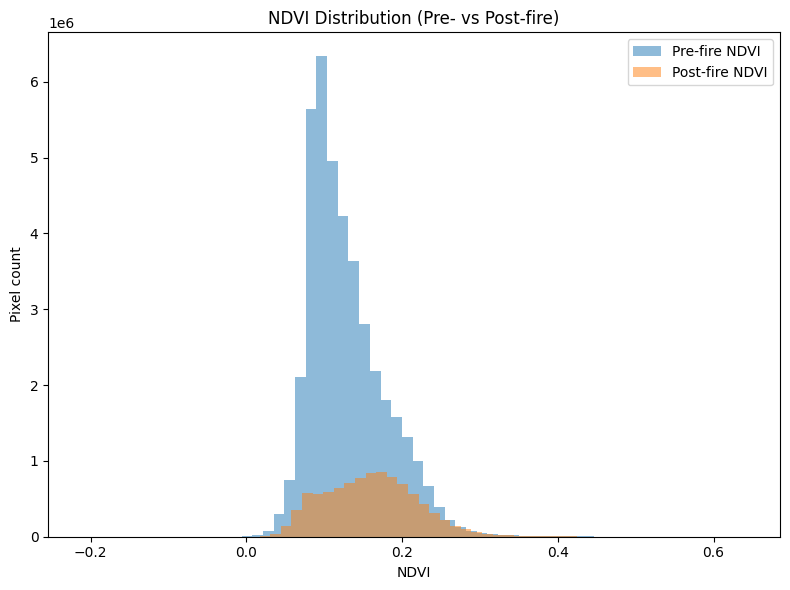

Saved: C:\Users\Rbrig\fossil_creek_project\figs\ndvi_hist_pre_post.png


In [15]:
##plot & save NDVI pre/post histograms for EDA

import matplotlib.pyplot as plt

finite_pre  = np.isfinite(ndvi_pre)
finite_post = np.isfinite(ndvi_post)

fig, ax = plt.subplots()
ax.hist(ndvi_pre[finite_pre],  bins=60, alpha=0.5, label="Pre-fire NDVI")
ax.hist(ndvi_post[finite_post], bins=60, alpha=0.5, label="Post-fire NDVI")

ax.set_title("NDVI Distribution (Pre- vs Post-fire)")
ax.set_xlabel("NDVI")
ax.set_ylabel("Pixel count")
ax.legend()

plt.tight_layout()
out_path = FIG_DIR / "ndvi_hist_pre_post.png"
plt.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)


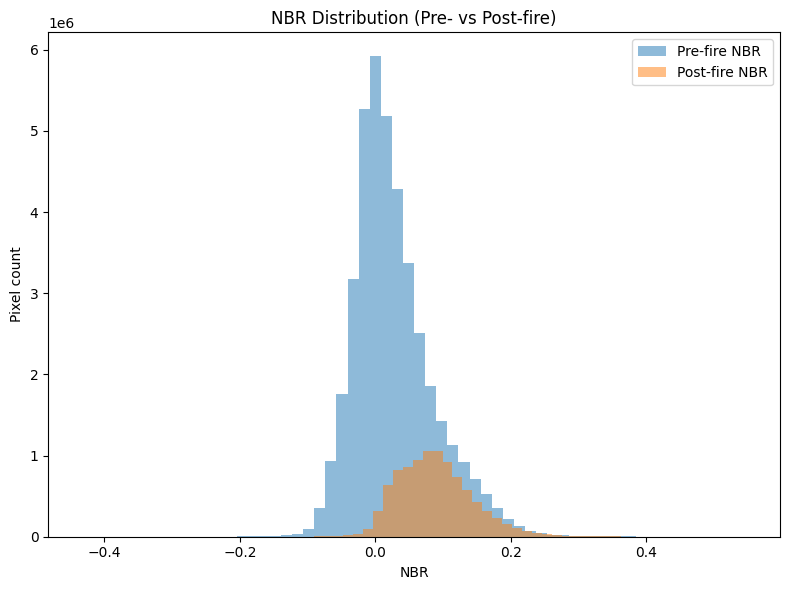

Saved: C:\Users\Rbrig\fossil_creek_project\figs\nbr_hist_pre_post.png


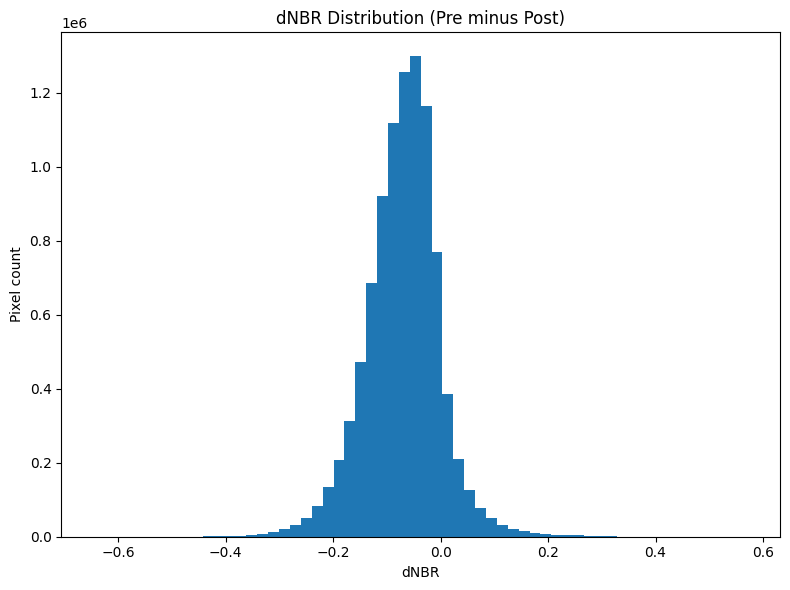

Saved: C:\Users\Rbrig\fossil_creek_project\figs\dnbr_hist.png


In [16]:
##plot & save NBR/dNBR histograms for EDA

finite_nbr_pre  = np.isfinite(nbr_pre)
finite_nbr_post = np.isfinite(nbr_post)
finite_dnbr     = np.isfinite(dnbr)

# NBR pre vs post
fig, ax = plt.subplots()
ax.hist(nbr_pre[finite_nbr_pre],  bins=60, alpha=0.5, label="Pre-fire NBR")
ax.hist(nbr_post[finite_nbr_post], bins=60, alpha=0.5, label="Post-fire NBR")
ax.set_title("NBR Distribution (Pre- vs Post-fire)")
ax.set_xlabel("NBR")
ax.set_ylabel("Pixel count")
ax.legend()
plt.tight_layout()
out_path = FIG_DIR / "nbr_hist_pre_post.png"
plt.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)

# dNBR
fig, ax = plt.subplots()
ax.hist(dnbr[finite_dnbr], bins=60)
ax.set_title("dNBR Distribution (Pre minus Post)")
ax.set_xlabel("dNBR")
ax.set_ylabel("Pixel count")
plt.tight_layout()
out_path = FIG_DIR / "dnbr_hist.png"
plt.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)


NDVI change range: -0.485 to 0.519


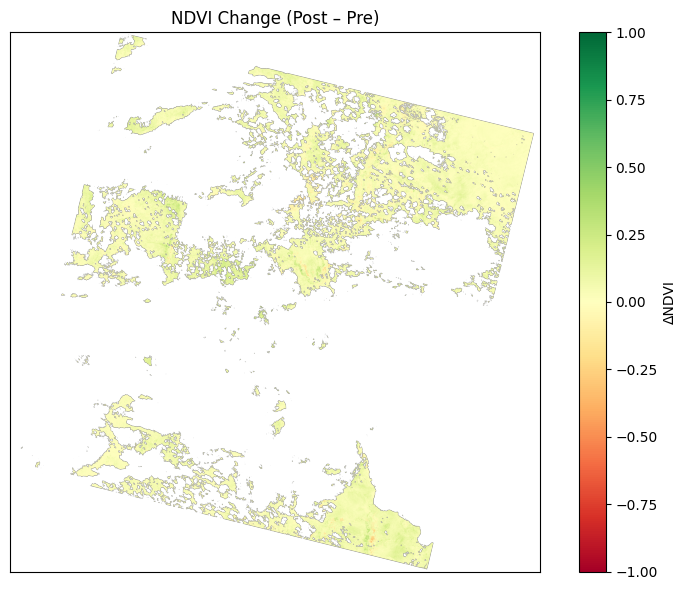

Saved: C:\Users\Rbrig\fossil_creek_project\figs\ndvi_change_map.png


In [17]:
##visualize & save NDVI change map (post - pre)

ndvi_change = ndvi_post - ndvi_pre
finite_change = np.isfinite(ndvi_change)

print_range("NDVI change", ndvi_change)

fig, ax = plt.subplots()
im = ax.imshow(ndvi_change, cmap="RdYlGn", vmin=-1, vmax=1)
ax.set_title("NDVI Change (Post – Pre)")
ax.set_xticks([])
ax.set_yticks([])
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("ΔNDVI")

plt.tight_layout()
out_path = FIG_DIR / "ndvi_change_map.png"
plt.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)


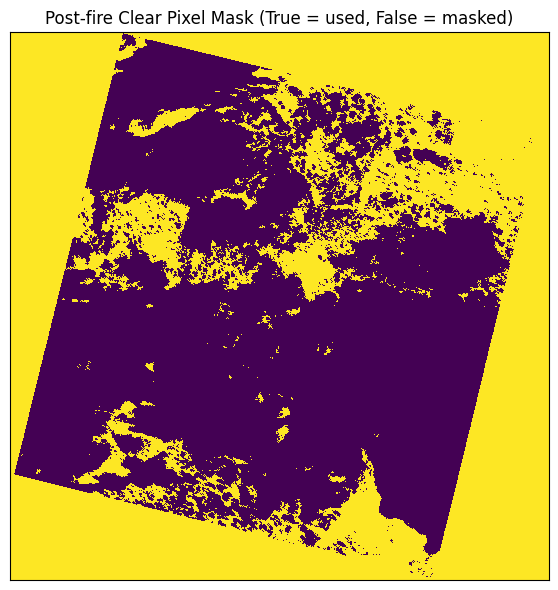

Saved: C:\Users\Rbrig\fossil_creek_project\figs\clear_mask_postfire.png


In [18]:
#visualize and save clear pixel mask for post-fire scene

fig, ax = plt.subplots()
im = ax.imshow(clear_post, interpolation="none")
ax.set_title("Post-fire Clear Pixel Mask (True = used, False = masked)")
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
out_path = FIG_DIR / "clear_mask_postfire.png"
plt.savefig(out_path, dpi=300)
plt.show()
print("Saved:", out_path)


Overall, the Backbone Fire burned roughly 21% of the Fossil Creek HU10 (~165 km²). Histograms of NBR show a clear shift toward lower values after the fire, and dNBR is mostly positive, indicating substantial canopy loss in the burned portion of the watershed. The valid-data mask confirms that most of the AOI is cloud free for the selected dates, so NDVI/NBR-based metrics are reliable for subsequent modeling. These EDA results motivate focusing on relationships between burn severity, terrain variables, and NDVI/EVI recovery in the next stages of the project